In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from random import choices, sample
from gensim.models import Word2Vec
import gc
pd.set_option('display.float_format',lambda x : '%.2f' % x)
from math import log10

In [2]:
with open('./NN_result/lt_df_NN_rank_9days.pkl', 'rb') as file:
    lt_df_NN_rank = pickle.load(file)

In [3]:
full_table = pd.concat(lt_df_NN_rank[1:1+4], ignore_index=True)

In [4]:
full_table['dist'] = full_table.apply(lambda df: df['rank'] - df['NN_rank'], axis=1)

In [5]:
full_table

,target,next,rank,NN_rank,dist
0,2063176,1793668,53.00,40,13.00
1,1036421,215370,26.00,50,-24.00
2,1036421,215370,26.00,50,-24.00
3,4364467,632080,19.00,2,17.00
4,632080,4272037,20.00,61,-41.00
...,...,...,...,...,...
952774,3087929,3292913,88.00,52,36.00
952775,4082039,3801509,48.00,92,-44.00
952776,932794,488456,80.00,20,60.00
952777,1354952,1846009,39.00,1,38.00


In [6]:
full_table.describe()

,rank,NN_rank,dist
count,952779.00,952779.00,952779.00
mean,30.48,32.24,-1.77
std,28.11,27.69,33.35
min,1.00,1.00,-98.00
25%,6.00,8.00,-21.00
50%,21.00,24.00,-1.00
75%,50.00,51.00,16.00
max,99.00,99.00,98.00


In [7]:
table_grby = full_table.groupby(['target'])
pd.DataFrame(table_grby.size())

,0
target,
100000,1
1000061,1
100021,3
1000294,1
1000300,22
...,...
999686,1
999712,77
999752,1


In [8]:
df_table  = pd.merge(full_table, pd.DataFrame(table_grby.size()), on=['target'], how='left')

In [9]:
df_table.rename(columns = {0:'occur'}, inplace=True)

In [10]:
# df_table.drop_duplicates(inplace=True, ignore_index=True)

In [11]:
df_table

,target,next,rank,NN_rank,dist,occur
0,2063176,1793668,53.00,40,13.00,35
1,1036421,215370,26.00,50,-24.00,3
2,1036421,215370,26.00,50,-24.00,3
3,4364467,632080,19.00,2,17.00,342
4,632080,4272037,20.00,61,-41.00,648
...,...,...,...,...,...,...
952774,3087929,3292913,88.00,52,36.00,1
952775,4082039,3801509,48.00,92,-44.00,65
952776,932794,488456,80.00,20,60.00,41
952777,1354952,1846009,39.00,1,38.00,36


In [12]:
df_table.describe()

,rank,NN_rank,dist,occur
count,952779.00,952779.00,952779.00,952779.00
mean,30.48,32.24,-1.77,182.20
std,28.11,27.69,33.35,266.91
min,1.00,1.00,-98.00,1.00
25%,6.00,8.00,-21.00,23.00
50%,21.00,24.00,-1.00,82.00
75%,50.00,51.00,16.00,230.00
max,99.00,99.00,98.00,2275.00


In [13]:
df_table.groupby('occur').mean().describe()

,rank,NN_rank,dist
count,547.00,547.00,547.00
mean,26.18,25.36,0.83
std,7.81,7.91,8.06
min,3.13,4.48,-42.72
25%,21.34,19.36,-4.19
50%,26.86,25.23,-0.34
75%,31.11,30.28,5.31
max,55.28,49.19,32.90


---

In [14]:
model_w2v = Word2Vec.load("iid_1days.model")

In [15]:
df_table['Ground_Truth'] = df_table.apply(lambda df: df['rank'] > df['NN_rank'], axis=1)

In [16]:
max_occur = max(df_table['occur'])

In [17]:
df_table['occur_log'] = df_table.apply(lambda df: log10(df['occur'])/log10(max_occur), axis=1)

In [18]:
df_table

,target,next,rank,NN_rank,dist,occur,Ground_Truth,occur_log
0,2063176,1793668,53.00,40,13.00,35,True,0.46
1,1036421,215370,26.00,50,-24.00,3,False,0.14
2,1036421,215370,26.00,50,-24.00,3,False,0.14
3,4364467,632080,19.00,2,17.00,342,True,0.75
4,632080,4272037,20.00,61,-41.00,648,False,0.84
...,...,...,...,...,...,...,...,...
952774,3087929,3292913,88.00,52,36.00,1,True,0.00
952775,4082039,3801509,48.00,92,-44.00,65,False,0.54
952776,932794,488456,80.00,20,60.00,41,True,0.48
952777,1354952,1846009,39.00,1,38.00,36,True,0.46


In [19]:
training_data = []
not_exist_id = []
Ground_Truth = []
for row in tqdm(df_table.iterrows()):
    if row[1]['target'] not in model_w2v.wv:
        not_exist_id.append(row[1]['target'])
        continue
    training_data.append(np.append(model_w2v.wv[row[1]['target']], [row[1]['occur_log']]))
    Ground_Truth.append(row[1]['Ground_Truth'])

952779it [01:44, 9145.28it/s]


In [20]:
training_data = np.array(training_data)

In [21]:
len(Ground_Truth)

952779

In [22]:
X_train, y_train = training_data, Ground_Truth

In [23]:
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, losses, metrics, callbacks

Using TensorFlow backend.


In [24]:
model = models.Sequential()
model.add(layers.Dense(512, activation='linear', input_shape=(129,)))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(256, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(128, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(64, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.mse])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               66560     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [27]:
# checkpoint
filepath = './saved_model/' + 'switch' + '_' + time.strftime("%m%d", time.localtime()) + ".h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [28]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=.3,
                    verbose=1,
                    callbacks=callbacks_list)

Train on 666945 samples, validate on 285834 samples
Epoch 1/20
666945/666945 [==============================] - 14s 20us/step - loss: 0.6663 - mean_squared_error: 0.2365 - val_loss: 0.6623 - val_mean_squared_error: 0.2344

Epoch 00001: val_loss improved from inf to 0.66227, saving model to ./saved_model/switch_0429.h5
Epoch 2/20
666945/666945 [==============================] - 13s 20us/step - loss: 0.6600 - mean_squared_error: 0.2337 - val_loss: 0.6820 - val_mean_squared_error: 0.2426

Epoch 00002: val_loss did not improve from 0.66227
Epoch 3/20
666945/666945 [==============================] - 14s 20us/step - loss: 0.6575 - mean_squared_error: 0.2326 - val_loss: 0.6575 - val_mean_squared_error: 0.2328

Epoch 00003: val_loss improved from 0.66227 to 0.65751, saving model to ./saved_model/switch_0429.h5
Epoch 4/20
666945/666945 [==============================] - 13s 20us/step - loss: 0.6561 - mean_squared_error: 0.2320 - val_loss: 0.6560 - val_mean_squared_error: 0.2320

Epoch 00004: va

In [29]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

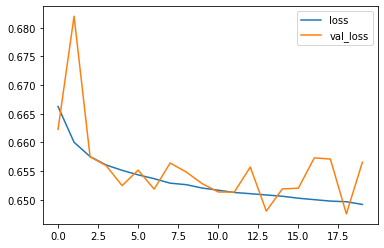

In [30]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

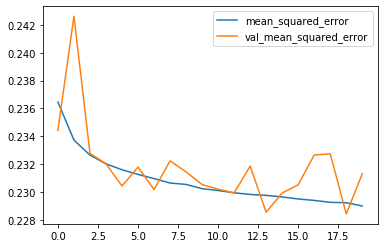

In [31]:
pd.DataFrame(history.history)[['mean_squared_error', 'val_mean_squared_error']].plot()

In [33]:
model = models.load_model('./saved_model/switch_0429.h5')

---

In [34]:
df_table_testday = pd.concat(lt_df_NN_rank[1+4:], ignore_index=True)

In [35]:
df_table_testday.drop_duplicates(inplace=True, ignore_index=True)

In [36]:
df_table_testday.describe()

,rank,NN_rank
count,308215.00,308215.00
mean,39.75,42.04
std,29.02,28.67
min,1.00,1.00
25%,14.00,17.00
50%,35.00,38.00
75%,63.00,65.00
max,99.00,99.00


In [37]:
df_table_testday = pd.merge(df_table_testday, pd.DataFrame(table_grby.size()), on=['target'], how='left')

In [38]:
df_table_testday.rename(columns = {0:'occur'}, inplace=True)

In [39]:
df_table_testday['occur'].fillna(1, inplace=True)

In [40]:
def pred(df):
    if df['target'] not in model_w2v.wv:
        return 0
    else:
        return model.predict(np.append(model_w2v.wv[df['target']], df['occur_log']).reshape(1, -1))[0][0]

In [41]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [42]:
max_occur = max(df_table_testday['occur'])

In [43]:
def add_features(df_table_testday):
    df_table_testday['Ground_Truth'] = df_table_testday.apply(lambda df: df['rank'] > df['NN_rank'], axis=1)
    df_table_testday['occur_log'] = df_table_testday.apply(lambda df: log10(df['occur'])/log10(max_occur), axis=1)
    return df_table_testday

In [44]:
df_table_testday = parallelize_dataframe(df_table_testday, add_features)

In [45]:
df_table_testday['pred_score'] = df_table_testday.apply(pred, axis=1)

In [46]:
def add_features(df_table_testday):
    df_table_testday['pred'] = df_table_testday.apply(lambda df: True if df['pred_score'] > 0.5 else False, axis=1)
    df_table_testday['pred_switch'] = df_table_testday.apply(lambda df: df['NN_rank'] if df['pred'] else df['rank'], axis=1)
    return df_table_testday

In [47]:
df_table_testday = parallelize_dataframe(df_table_testday, add_features)

In [48]:
df_table_testday

,target,next,rank,NN_rank,occur,Ground_Truth,occur_log,pred_score,pred,pred_switch
0,4449648,1580138,77.00,81,5.00,False,0.21,0.42,False,77.00
1,1674582,3574186,54.00,58,38.00,False,0.47,0.55,True,58.00
2,3715112,1712849,2.00,23,1026.00,False,0.90,0.85,True,23.00
3,1712849,3715112,1.00,1,40.00,False,0.48,0.54,True,1.00
4,3715112,4546029,14.00,15,1026.00,False,0.90,0.85,True,15.00
...,...,...,...,...,...,...,...,...,...,...
308210,3244585,46310,52.00,88,6.00,False,0.23,0.38,False,52.00
308211,3586172,3904916,73.00,6,1.00,True,0.00,0.50,True,6.00
308212,1322280,1535093,68.00,81,1.00,False,0.00,0.46,False,68.00
308213,3670405,845698,72.00,17,1.00,True,0.00,0.46,False,72.00


In [49]:
df_table_testday.describe()

,rank,NN_rank,occur,occur_log,pred_score,pred_switch
count,308215.00,308215.00,308215.00,308215.00,308215.00,308215.00
mean,39.75,42.04,74.27,0.39,0.44,38.20
std,29.02,28.67,141.34,0.23,0.11,28.39
min,1.00,1.00,1.00,0.00,0.01,1.00
25%,14.00,17.00,5.00,0.21,0.39,13.00
50%,35.00,38.00,23.00,0.41,0.45,33.00
75%,63.00,65.00,80.00,0.57,0.51,60.00
max,99.00,99.00,2275.00,1.00,0.93,99.00


In [50]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(df_table_testday['Ground_Truth'].tolist(),df_table_testday['pred']))

              precision    recall  f1-score   support

       False       0.58      0.77      0.66    169519
        True       0.54      0.33      0.41    138696

    accuracy                           0.57    308215
   macro avg       0.56      0.55      0.54    308215
weighted avg       0.56      0.57      0.55    308215

